In [ ]:
# The extra features present are:
# Flow ID
# Source IP
# Source Port
# Destination IP
# Protocol
# Timestamp

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import csv

veri= pd.read_csv("./2019-Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", delimiter=',', skiprows=0, low_memory=False)
veri.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [3]:
veri[' Label'].replace(['BENIGN','DDoS'],[0,1],inplace=True)

C:\Users\HP-PC\AppData\Local\Temp\ipykernel_3484\2683523564.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\HP-PC\AppData\Local\Temp\ipykernel_3484\2683523564.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [4]:
moddf= veri.dropna()
moddf.shape

(225741, 85)

In [5]:
moddf.isna().any()[lambda x:x]

Series([], dtype: bool)

In [6]:
del moddf[' Flow Packets/s']

In [7]:
moddf.shape

(225741, 84)

In [18]:
features=[" Destination Port" , "Bwd Packet Length Max", " Bwd Packet Length Mean" , " Bwd Packet Length Std", " Packet Length Mean", " URG Flag Count", " Average Packet Size", " Avg Bwd Segment Size"," Flow Duration"," Total Fwd Packets"," Subflow Bwd Packets"," Source IP"," Destination IP"," Protocol"," Label"]

In [19]:
len(features)

15

In [20]:
X=moddf[features].copy()
X.head()

,Destination Port,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Packet Length Mean,URG Flag Count,Average Packet Size,Avg Bwd Segment Size,Flow Duration,Total Fwd Packets,Subflow Bwd Packets,Source IP,Destination IP,Protocol,Label
0,54865,0,0.0,0.0,6.0,0,9.0,0.0,3,2,0,104.16.207.165,192.168.10.5,6,0
1,55054,6,6.0,0.0,6.0,1,9.0,6.0,109,1,1,104.16.28.216,192.168.10.5,6,0
2,55055,6,6.0,0.0,6.0,1,9.0,6.0,52,1,1,104.16.28.216,192.168.10.5,6,0
3,46236,6,6.0,0.0,6.0,1,9.0,6.0,34,1,1,104.17.241.25,192.168.10.16,6,0
4,54863,0,0.0,0.0,6.0,0,9.0,0.0,3,2,0,104.19.196.102,192.168.10.5,6,0


In [21]:
giris = X.iloc[:,0:10]
cikis = X.iloc[:,-1]

In [22]:
print(cikis)

0         0
1         0
2         0
3         0
4         0
         ..
225740    0
225741    0
225742    0
225743    0
225744    0
Name:  Label, Length: 225741, dtype: int64


In [23]:
from sklearn.model_selection import train_test_split as tts
xtrain, xtest, ytrain, ytest = tts(giris, cikis, test_size=0.2)
xtrain

,Destination Port,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Packet Length Mean,URG Flag Count,Average Packet Size,Avg Bwd Segment Size,Flow Duration,Total Fwd Packets
118902,80,0,0.000000,0.000000,6.000000,0,7.500000,0.000000,9218925,4
186546,40843,6,6.000000,0.000000,6.000000,1,7.000000,6.000000,4259461,1
104198,50251,20,13.000000,9.899495,1292.555556,0,1454.125000,13.000000,1870212,6
13825,53,87,87.000000,0.000000,57.000000,0,85.500000,87.000000,47283,1
81852,80,0,0.000000,0.000000,6.000000,0,7.500000,0.000000,10090729,4
...,...,...,...,...,...,...,...,...,...,...
39405,80,7215,2321.400000,3327.769794,833.500000,0,897.615385,2321.400000,72695700,8
79174,59891,6,6.000000,0.000000,6.000000,1,7.000000,6.000000,1930676,1
1007,53,80,80.000000,0.000000,53.600000,0,67.000000,80.000000,23957,2
219167,53,57,57.000000,0.000000,47.400000,0,59.250000,57.000000,170,2


In [24]:

import tensorflow as tf
from keras.layers import Dense, BatchNormalization, Dropout, LSTM, Bidirectional
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [26]:
x_train , y_train = np.array(xtrain), np.array(ytrain)
x_train = np.reshape(x_train, (xtrain.shape[0] , xtrain.shape[1], 1) )

In [27]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1],1) ) )) #çıktı uzayının boyutu
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1,activation='sigmoid'))
regressor.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
regressor.fit(x_train, y_train, epochs=10,batch_size=128 )

Epoch 1/10


C:\Users\HP-PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1411/1411 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - acc: 0.8860 - loss: 0.2565
Epoch 2/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - acc: 0.9898 - loss: 0.0412
Epoch 3/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - acc: 0.9972 - loss: 0.0146
Epoch 4/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - acc: 0.9976 - loss: 0.0117
Epoch 5/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - acc: 0.9971 - loss: 0.0124
Epoch 6/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - acc: 0.9978 - loss: 0.0095
Epoch 7/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - acc: 0.9978 - loss: 0.0091
Epoch 8/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - acc: 0.9977 - loss: 0.0095
Epoch 9/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - acc: 0.9980 - loss: 0.0081
Epoch 10/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - acc: 0.9983 - loss: 0.0062


In [28]:
trainloss=regressor.evaluate(x_train,y_train,verbose=0)

In [29]:
x_test , y_test = np.array(xtest), np.array(ytest)
x_test = np.reshape(x_test, (xtest.shape[0] , xtest.shape[1], 1) )

In [30]:
testloss=regressor.evaluate(x_test,y_test,verbose=0)

In [31]:
predict = regressor.predict(x_test)

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step


In [32]:
xtest.shape[1]

10

In [33]:
predict

array([[9.9996674e-01],
       [2.2589673e-05],
       [1.3779882e-01],
       ...,
       [9.9996716e-01],
       [9.9998027e-01],
       [9.9997944e-01]], dtype=float32)

In [34]:
predDf = pd.DataFrame(y_test,columns=["Real predictions:"])

In [35]:
predDf

,Real predictions:
0,1
1,0
2,0
3,0
4,0
...,...
45144,0
45145,0
45146,1
45147,1


In [36]:
predDf2 = pd.Series(predict.reshape(45149,))
predDf2

0        0.999967
1        0.000023
2        0.137799
3        0.000022
4        0.000023
           ...   
45144    0.000021
45145    0.000027
45146    0.999967
45147    0.999980
45148    0.999979
Length: 45149, dtype: float32

In [37]:
pred_results=pd.concat([predDf,predDf2],axis=1)
pred_results

,Real predictions:,0
0,1,0.999967
1,0,0.000023
2,0,0.137799
3,0,0.000022
4,0,0.000023
...,...,...
45144,0,0.000021
45145,0,0.000027
45146,1,0.999967
45147,1,0.999980


In [38]:
pred_results.columns=['Real_Values', 'Predicted_Values']

In [39]:
pred_results

,Real_Values,Predicted_Values
0,1,0.999967
1,0,0.000023
2,0,0.137799
3,0,0.000022
4,0,0.000023
...,...,...
45144,0,0.000021
45145,0,0.000027
45146,1,0.999967
45147,1,0.999980


In [40]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
errorAb=mean_absolute_error(pred_results["Real_Values"], pred_results["Predicted_Values"])
errorSQ=mean_squared_error(pred_results["Real_Values"], pred_results["Predicted_Values"])

In [41]:
errorAb

0.001861949041720738

In [42]:
errorSQ

0.0009699563627121005

In [43]:
predict

array([[9.9996674e-01],
       [2.2589673e-05],
       [1.3779882e-01],
       ...,
       [9.9996716e-01],
       [9.9998027e-01],
       [9.9997944e-01]], dtype=float32)

In [44]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1],1) ) )) #çıktı uzayının boyutu
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1,activation='sigmoid'))
regressor.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
history=regressor.fit(x_train, y_train, epochs=3,batch_size=64 )

Epoch 1/3


C:\Users\HP-PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2822/2822 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - acc: 0.9224 - loss: 0.1857
Epoch 2/3
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 58s 21ms/step - acc: 0.9947 - loss: 0.0256
Epoch 3/3
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 57s 20ms/step - acc: 0.9967 - loss: 0.0136


dict_keys(['acc', 'loss'])


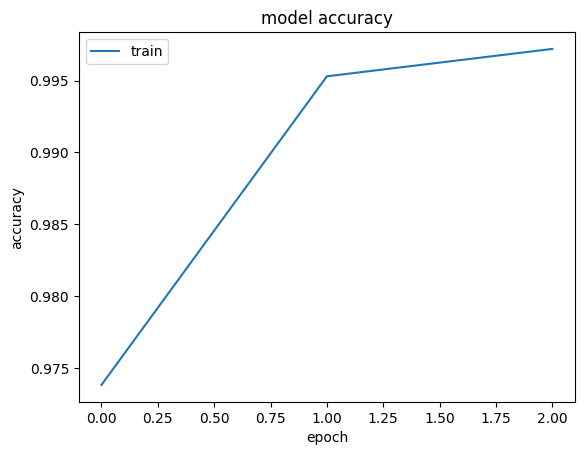

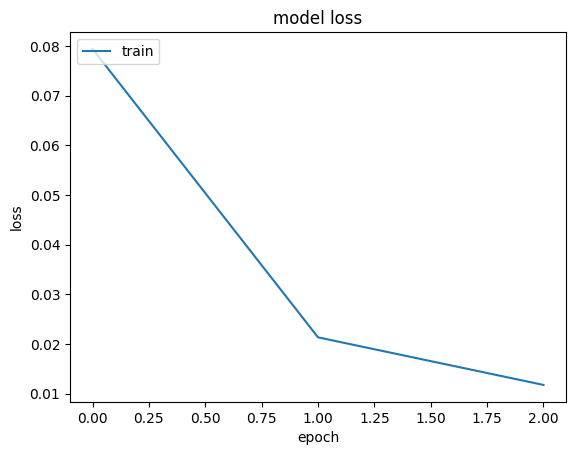

In [45]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()